In [1]:
import pandas
from pandas import read_excel, date_range, DatetimeIndex, DataFrame, to_numeric, concat, to_datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from pandas.tseries.offsets import DateOffset, MonthEnd, MonthBegin

import numpy
from numpy import logical_not

import statistics
import dateutil.relativedelta
from dateutil.relativedelta import relativedelta

import fbprophet
from fbprophet import Prophet

import calendar
from calendar import monthrange

from datetime import datetime, timedelta
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error, mean_squared_error

from math import sqrt

Importing plotly failed. Interactive plots will not work.


In [2]:
# esto no va en produccion

# cambiamos el valor de estos 4 parametros para que nos muestre dataframes sin truncarlos
pandas.set_option('display.max_rows', 12)
# pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

In [3]:
# vamos a crear una serie temporal agrupando el gasto por meses

In [4]:
# Load data using read_excel
transacciones_df = read_excel('20210513 mmelero (249236).xlsx', sheet_name='Hoja1')
transacciones_df

,Fecha transacción,Importe,ID Categoría,Nombre categoría,Nivel categoría,iD categoría padre,Nombre categoría padre,Proveedor,Marca,Sector,Financiero,Transferencia,Unnamed: 12,Unnamed: 13,ID,BALANCE,BALANCE_DATE
0,2020-07-24,-1.20,84.0,parking_84,2.0,5.0,vehiculos_5,NaN,NaN,NaN,False,False,NaN,NaN,249236.0,1478.98,2020-07-26
1,2020-07-23,-4.50,117.0,regalos_celebraciones_117,2.0,8.0,gastos_personales_8,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
2,2020-07-23,-13.53,70.0,supermercados_70,2.0,4.0,alimentacion_4,SPAR,SPAR,Supermercados,False,False,NaN,NaN,NaN,NaN,NaT
3,2020-07-22,-51.40,222.0,adsl_222,3.0,521.0,Comunicaciones y TV,Jazz Telecom,Jazztel,Compañías telecomunicaciones,False,False,NaN,NaN,NaN,NaN,NaT
4,2020-07-22,-11.00,70.0,supermercados_70,2.0,4.0,alimentacion_4,Mercadona,Mercadona,Supermercados,False,False,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2016-09-05,1533.02,18.0,retribucion_liquida_18,3.0,576.0,Nómina,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
1483,2016-09-05,-617.47,126.0,liquidacion_tarjeta_126,3.0,478.0,tarjetas_credito_478,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaT
1484,2016-09-05,-138.08,125.0,cuotas_125,3.0,127.0,otros_pasivos_127,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN,NaT
1485,2016-09-01,-32.22,90.0,seguro_salud_90,2.0,6.0,salud_6,Sanitas S.A. de Seguros,Sanitas,Seguros de salud,True,False,NaN,NaN,NaN,NaN,NaT


In [5]:
# nos quedamos con la fecha en que nos dan los datos de las transacciones
last_date_obj = transacciones_df.loc[0, 'BALANCE_DATE']
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [6]:
# nos quedamos con las transacciones de la categoría 'restaurantes_salidas_116'
transacciones_restaurantes_df = transacciones_df[transacciones_df['ID Categoría'] == 116.0]
transacciones_restaurantes_df

,Fecha transacción,Importe,ID Categoría,Nombre categoría,Nivel categoría,iD categoría padre,Nombre categoría padre,Proveedor,Marca,Sector,Financiero,Transferencia,Unnamed: 12,Unnamed: 13,ID,BALANCE,BALANCE_DATE
10,2020-07-20,-44.60,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
14,2020-07-16,-12.90,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
21,2020-07-14,-18.90,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
35,2020-07-06,-44.50,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
36,2020-07-06,-7.00,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,2016-10-24,-43.50,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
1450,2016-10-21,-10.30,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT
1454,2016-10-13,-20.95,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,Viena,Viena,Restaurante,False,False,NaN,NaN,NaN,NaN,NaT
1460,2016-10-10,-9.95,116.0,restaurantes_salidas_116,2.0,9.0,ocio_9,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaT


In [8]:
# nos quedamos con columnas desde 'Fecha transacción' hasta 'Importe'
transacciones_restaurantes_df = transacciones_restaurantes_df.iloc[:, 0:2]
transacciones_restaurantes_df

,Fecha transacción,Importe
10,2020-07-20,-44.60
14,2020-07-16,-12.90
21,2020-07-14,-18.90
35,2020-07-06,-44.50
36,2020-07-06,-7.00
...,...,...
1443,2016-10-24,-43.50
1450,2016-10-21,-10.30
1454,2016-10-13,-20.95
1460,2016-10-10,-9.95


In [9]:
# ya no necesitamos transacciones_df
del transacciones_df

In [10]:
# renombramos columnas
transacciones_restaurantes_df.rename(columns={'Fecha transacción': 'FECHA', 'Importe': 'IMPORTE'}, inplace=True)
transacciones_restaurantes_df

,FECHA,IMPORTE
10,2020-07-20,-44.60
14,2020-07-16,-12.90
21,2020-07-14,-18.90
35,2020-07-06,-44.50
36,2020-07-06,-7.00
...,...,...
1443,2016-10-24,-43.50
1450,2016-10-21,-10.30
1454,2016-10-13,-20.95
1460,2016-10-10,-9.95


In [11]:
# ordenamos las fechas por orden ascendente
transacciones_restaurantes_df.sort_values(by=['FECHA'], ascending=True, inplace=True, ignore_index=True)
transacciones_restaurantes_df

,FECHA,IMPORTE
0,2016-10-06,-8.50
1,2016-10-10,-9.95
2,2016-10-13,-20.95
3,2016-10-21,-10.30
4,2016-10-24,-43.50
...,...,...
143,2020-07-06,-7.00
144,2020-07-06,-44.50
145,2020-07-14,-18.90
146,2020-07-16,-12.90


In [12]:
# vamos a agrupar los valores y sumarlos por fecha
transacciones_restaurantes_df = transacciones_restaurantes_df.groupby(['FECHA']).sum()
transacciones_restaurantes_df

,IMPORTE
FECHA,
2016-10-06,-8.50
2016-10-10,-9.95
2016-10-13,-20.95
2016-10-21,-10.30
2016-10-24,-43.50
...,...
2020-07-02,-4.30
2020-07-06,-108.10
2020-07-14,-18.90


In [13]:
# esto no va en produccion

# comprobamos que el indice sea datetime o DatetimeIndex
type(transacciones_restaurantes_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [14]:
# hacemos una columna con el indice
transacciones_restaurantes_df['FECHA'] = transacciones_restaurantes_df.index
transacciones_restaurantes_df

,IMPORTE,FECHA
FECHA,,
2016-10-06,-8.50,2016-10-06
2016-10-10,-9.95,2016-10-10
2016-10-13,-20.95,2016-10-13
2016-10-21,-10.30,2016-10-21
2016-10-24,-43.50,2016-10-24
...,...,...
2020-07-02,-4.30,2020-07-02
2020-07-06,-108.10,2020-07-06
2020-07-14,-18.90,2020-07-14


In [15]:
# esto no va en produccion

# comprobamos que 'FECHA' sea datetime
transacciones_restaurantes_df.dtypes

IMPORTE           float64
FECHA      datetime64[ns]
dtype: object

In [16]:
# sumamos la cuantía de las transacciones de cada mes y la suma la ponemos fecha del inicio de cada mes
transacciones_month_df = transacciones_restaurantes_df.groupby(pandas.Grouper(key='FECHA', freq="MS")).sum()
transacciones_month_df

,IMPORTE
FECHA,
2016-10-01,-180.10
2016-11-01,-60.30
2016-12-01,0.00
2017-01-01,-114.35
2017-02-01,-91.30
...,...
2020-03-01,0.00
2020-04-01,0.00
2020-05-01,-40.65


In [18]:
# ya no necesitamos transacciones_restaurantes_df
del transacciones_restaurantes_df

In [19]:
# para que los datos sean más fáciles de interpretar vamos a hacerlos todos positivos multiplicándolos por '-1'
transacciones_month_df['IMPORTE'] = -transacciones_month_df['IMPORTE']
transacciones_month_df

,IMPORTE
FECHA,
2016-10-01,180.10
2016-11-01,60.30
2016-12-01,-0.00
2017-01-01,114.35
2017-02-01,91.30
...,...
2020-03-01,-0.00
2020-04-01,-0.00
2020-05-01,40.65


In [20]:
# en transacciones_mfilled_df rellenaremos las fechas sin importe con el importe valido inmediatamente anterior
transacciones_mfilled_df = transacciones_month_df.copy()
transacciones_mfilled_df

,IMPORTE
FECHA,
2016-10-01,180.10
2016-11-01,60.30
2016-12-01,-0.00
2017-01-01,114.35
2017-02-01,91.30
...,...
2020-03-01,-0.00
2020-04-01,-0.00
2020-05-01,40.65


In [21]:
# ya no necesitamos transacciones_month_df
del transacciones_month_df

In [22]:
# hacemos una columna con la fecha del indice
transacciones_mfilled_df['FECHA'] = transacciones_mfilled_df.index
transacciones_mfilled_df

,IMPORTE,FECHA
FECHA,,
2016-10-01,180.10,2016-10-01
2016-11-01,60.30,2016-11-01
2016-12-01,-0.00,2016-12-01
2017-01-01,114.35,2017-01-01
2017-02-01,91.30,2017-02-01
...,...,...
2020-03-01,-0.00,2020-03-01
2020-04-01,-0.00,2020-04-01
2020-05-01,40.65,2020-05-01


In [23]:
# indice de fechas hasta el ultimo dia del mes para el cual hay datos
idx = date_range(start=transacciones_mfilled_df.FECHA.min(), end=transacciones_mfilled_df.FECHA.max() + MonthEnd(1))
idx

DatetimeIndex(['2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04',
               '2016-10-05', '2016-10-06', '2016-10-07', '2016-10-08',
               '2016-10-09', '2016-10-10',
               ...
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [24]:
# esto no va en produccion

# comprobamos que el indice de transacciones_mfilled_df es de tipo DatetimeIndex 
type(transacciones_mfilled_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [25]:
# rellenamos las missing dates en el indice
transacciones_mfilled_df = transacciones_mfilled_df.reindex(idx, fill_value='NaN')
transacciones_mfilled_df

,IMPORTE,FECHA
2016-10-01,180.1,2016-10-01
2016-10-02,NaN,NaT
2016-10-03,NaN,NaT
2016-10-04,NaN,NaT
2016-10-05,NaN,NaT
...,...,...
2020-07-27,NaN,NaT
2020-07-28,NaN,NaT
2020-07-29,NaN,NaT
2020-07-30,NaN,NaT


In [26]:
# hacemos drop de la columna FECHA
transacciones_mfilled_df.drop(columns='FECHA', inplace=True)
transacciones_mfilled_df

,IMPORTE
2016-10-01,180.1
2016-10-02,NaN
2016-10-03,NaN
2016-10-04,NaN
2016-10-05,NaN
...,...
2020-07-27,NaN
2020-07-28,NaN
2020-07-29,NaN
2020-07-30,NaN


In [27]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    object
dtype: object

In [28]:
# pasamos IMPORTE a formato 'numeric'
transacciones_mfilled_ser = transacciones_mfilled_df.T.squeeze()
transacciones_mfilled_ser

2016-10-01    180.1
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: object

In [29]:
transacciones_mfilled_ser = to_numeric(transacciones_mfilled_ser, errors='coerce')
transacciones_mfilled_ser

2016-10-01    180.1
2016-10-02      NaN
2016-10-03      NaN
2016-10-04      NaN
2016-10-05      NaN
              ...  
2020-07-27      NaN
2020-07-28      NaN
2020-07-29      NaN
2020-07-30      NaN
2020-07-31      NaN
Freq: D, Name: IMPORTE, Length: 1400, dtype: float64

In [30]:
transacciones_mfilled_df = DataFrame(transacciones_mfilled_ser)
del transacciones_mfilled_ser
transacciones_mfilled_df

,IMPORTE
2016-10-01,180.1
2016-10-02,NaN
2016-10-03,NaN
2016-10-04,NaN
2016-10-05,NaN
...,...
2020-07-27,NaN
2020-07-28,NaN
2020-07-29,NaN
2020-07-30,NaN


In [31]:
# esto no va en produccion

# comprobamos si el tipo de IMPORTE es numerico
transacciones_mfilled_df.dtypes

IMPORTE    float64
dtype: object

In [32]:
# rellenamos los NaN con el ultimo valor numérico anterior
transacciones_mfilled_df['IMPORTE'].fillna(method='ffill', inplace=True)
transacciones_mfilled_df

,IMPORTE
2016-10-01,180.1
2016-10-02,180.1
2016-10-03,180.1
2016-10-04,180.1
2016-10-05,180.1
...,...
2020-07-27,188.8
2020-07-28,188.8
2020-07-29,188.8
2020-07-30,188.8


In [33]:
# antes de hacer una prediccion con prophet vamos a comprobar si este serie 'transacciones_mfilled_df' es modelizable

In [34]:
# Time Series Data Visualization with Python
# https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [35]:
# 1. Time Series Line Plot

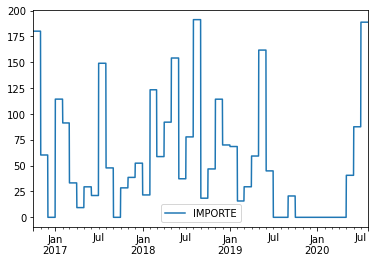

In [36]:
transacciones_mfilled_df.plot()
pyplot.show()

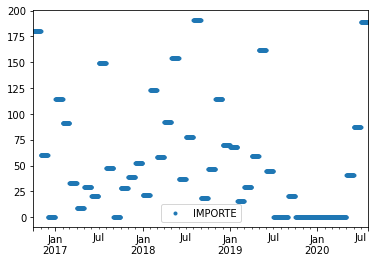

In [37]:
transacciones_mfilled_df.plot(style='.')
pyplot.show()

In [38]:
"""
no podemos obtener conclusiones claras sobre si esta serie es facil de modelizar.
pero sale un grafico del mismo tipo que el de 'supermercados' e incluso con los datos menos dispersos (supermercados de 0 a 400,
frente a restaurantes de 0 a 200)
"""

"\nno podemos obtener conclusiones claras sobre si esta serie es facil de modelizar.\npero sale un grafico del mismo tipo que el de 'supermercados' e incluso con los datos menos dispersos (supermercados de 0 a 400,\nfrente a restaurantes de 0 a 200)\n"

In [39]:
# 2. Time Series Histogram and Density Plots

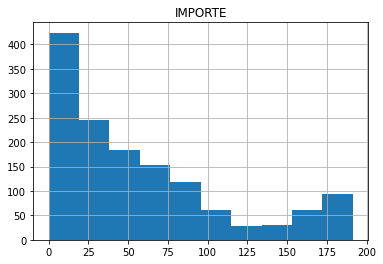

In [40]:
transacciones_mfilled_df.hist()
pyplot.show()

In [44]:
"""
Es una distribucion asimetrica a la derecha: moda (0) < mediana (40.65) < media (56.18).

min = 0
q1  = 09.39
q2  = 40.65
q3  = 87.60
max = 191.25

sale aun mas regular (bonita) y agrupada que la distribucion de 'supermercados'
"""

"\nEs una distribucion asimetrica a la derecha: moda (0) < mediana (40.65) < media (56.18).\n\nmin = 0\nq1  = 09.39\nq2  = 40.65\nq3  = 87.60\nmax = 191.25\n\nsale aun mas regular (bonita) y agrupada que la distribucion de 'supermercados'\n"

In [45]:
transacciones_mfilled_df.describe()

,IMPORTE
count,1400.000000
mean,56.185707
std,56.118156
min,-0.000000
25%,9.390000
50%,40.650000
75%,87.600000
max,191.250000


In [46]:
# calculamos la moda
stat_mode = statistics.mode(transacciones_mfilled_df['IMPORTE'])
stat_mode

-0.0

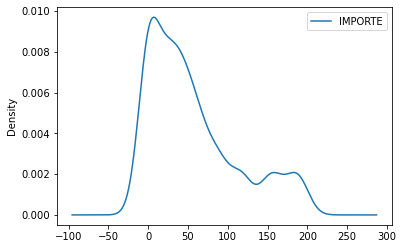

In [47]:
transacciones_mfilled_df.plot(kind='kde')
pyplot.show()

In [48]:
"""
el diagrama de densidad nos muestra que los gastos mas comunes (las modas) en la distribucion son 0 y 100-180 eur
aproximadamente
"""

'\nel diagrama de densidad nos muestra que los gastos mas comunes (las modas) en la distribucion son 0 y 100-180 eur\naproximadamente\n'

In [49]:
# 3. Time Series Box and Whisker Plots by Interval

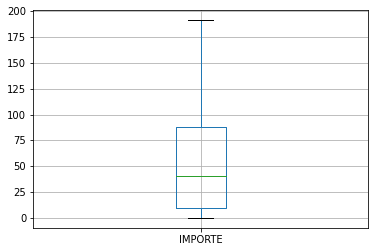

In [50]:
transacciones_mfilled_df.boxplot()
pyplot.show()

In [51]:
"""
Datos agrupados (más que en supermercados) y no hay outliers lo cual esta bien para q la serie sea modelable 
"""

'\nDatos agrupados (más que en supermercados) y no hay outliers lo cual esta bien para q la serie sea modelable \n'

In [52]:
# 4. Time Series Heat Maps

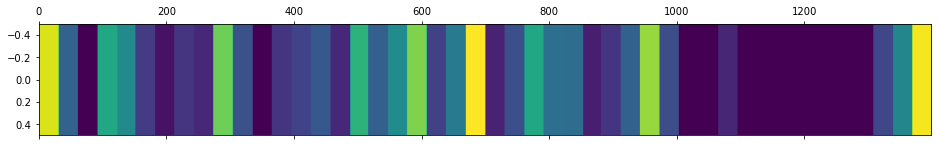

In [53]:
pyplot.matshow(transacciones_mfilled_df.T, interpolation=None, aspect='auto')
pyplot.show()

In [55]:
"""
El mapa de color no nos da nueva informacion respecto al grafico de la evolucion temporal de la serie.
Datos que no tienen grandes variaciones: la serie sera más fácil de modelizar.
"""

'\nEl mapa de color no nos da nueva informacion respecto al grafico de la evolucion temporal de la serie.\nDatos que no tienen grandes variaciones: la serie sera más fácil de modelizar.\n'

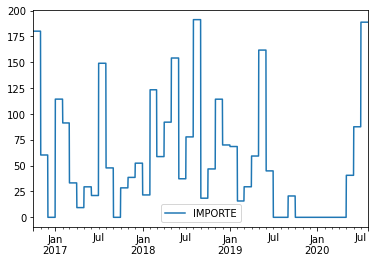

In [56]:
transacciones_mfilled_df.plot()
pyplot.show()

In [57]:
# 5. Time Series Lag Scatter Plots

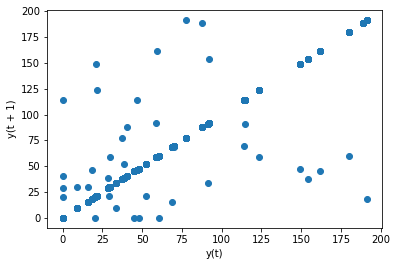

In [59]:
lag_plot(transacciones_mfilled_df)
pyplot.show()

In [60]:
"""
Vemos una correlacion muy clara (diagonal muy clara con poco ruido) entre y(t+1) e y(t) en todo el rango de valores
"""

'\nVemos una correlacion muy clara (diagonal muy clara con poco ruido) entre y(t+1) e y(t) en todo el rango de valores\n'

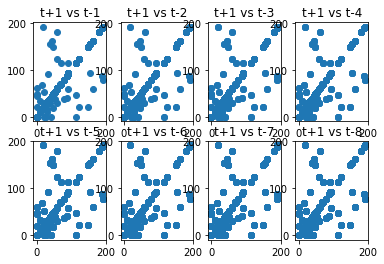

In [61]:
values = DataFrame(transacciones_mfilled_df.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
pyplot.figure(1)
for i in range(1,(lags + 1)):
	ax = pyplot.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
pyplot.show()

In [62]:
"""
Seguimos viendo correlaciones muy claras entre y(t+1) y sus 8 primeros lags
"""

'\nSeguimos viendo correlaciones muy claras entre y(t+1) y sus 8 primeros lags\n'

t+1 vs t-1


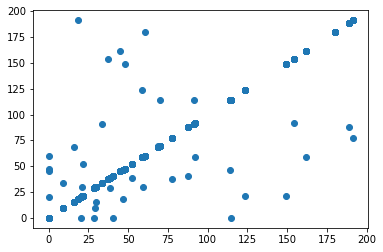

t+1 vs t-2


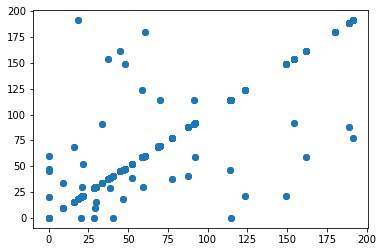

t+1 vs t-3


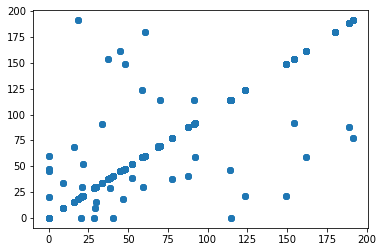

t+1 vs t-4


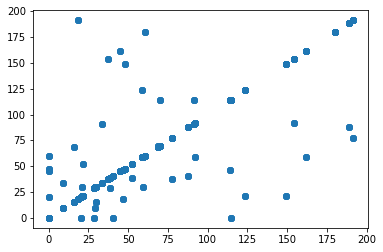

t+1 vs t-5


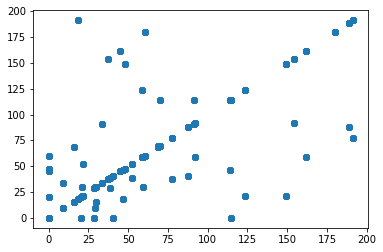

t+1 vs t-6


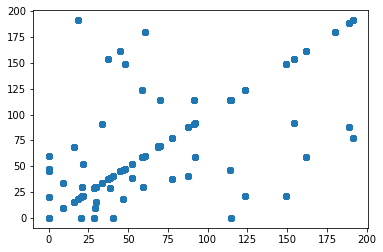

t+1 vs t-7


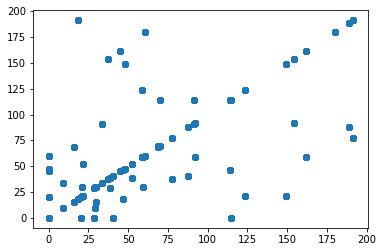

t+1 vs t-8


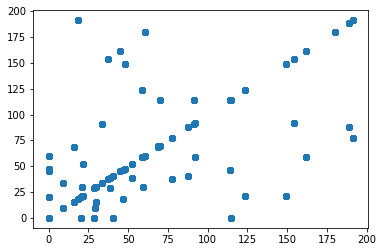

t+1 vs t-9


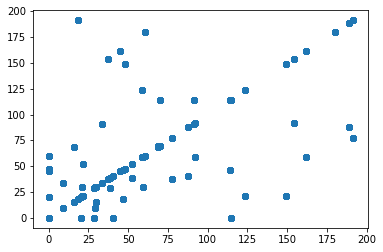

t+1 vs t-10


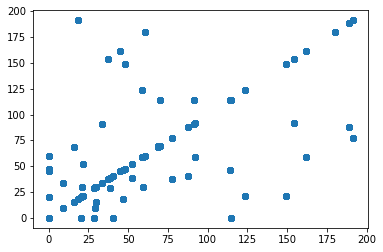

t+1 vs t-11


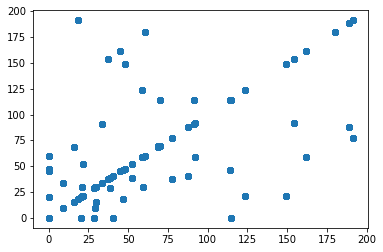

t+1 vs t-12


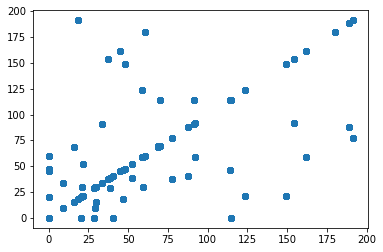

t+1 vs t-13


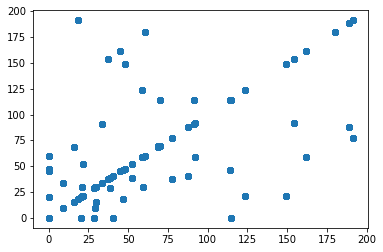

t+1 vs t-14


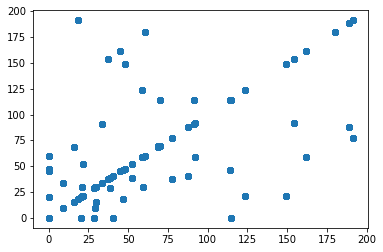

t+1 vs t-15


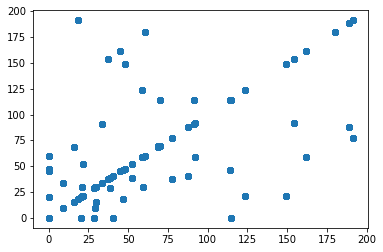

t+1 vs t-16


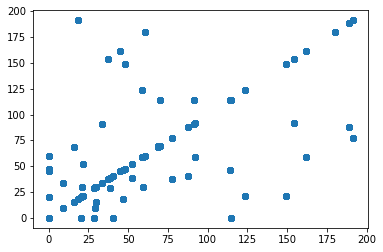

t+1 vs t-17


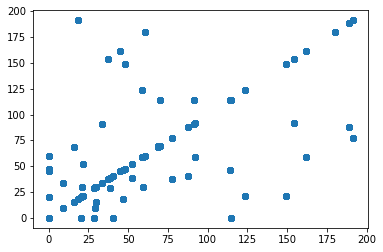

t+1 vs t-18


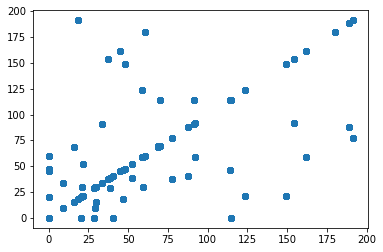

t+1 vs t-19


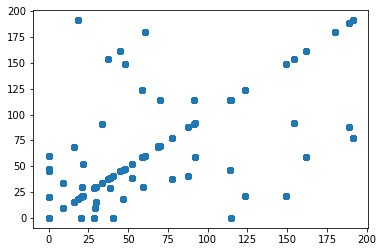

t+1 vs t-20


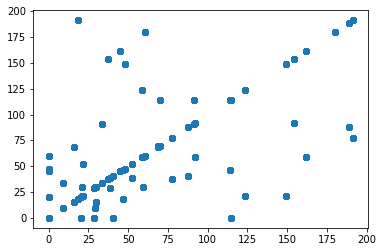

t+1 vs t-21


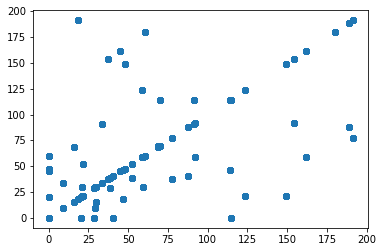

t+1 vs t-22


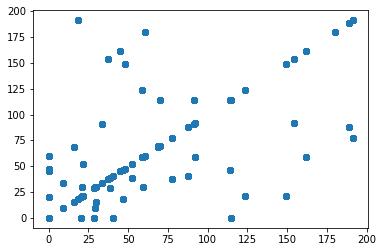

t+1 vs t-23


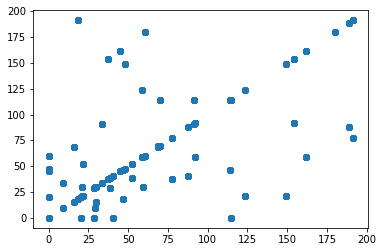

t+1 vs t-24


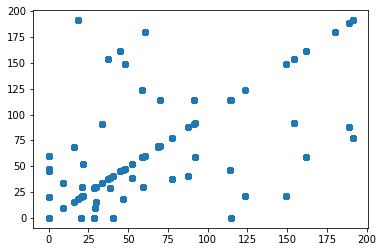

t+1 vs t-25


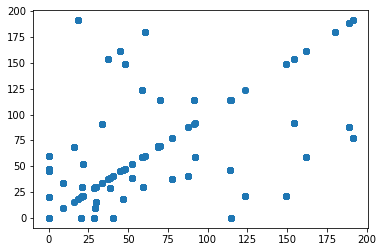

t+1 vs t-26


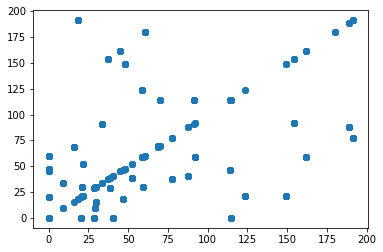

t+1 vs t-27


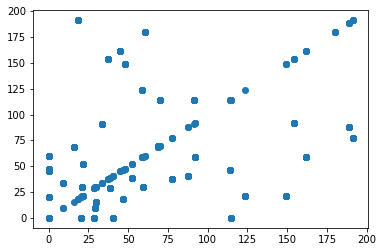

t+1 vs t-28


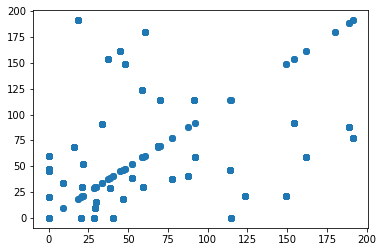

t+1 vs t-29


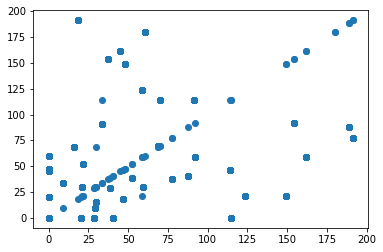

t+1 vs t-30


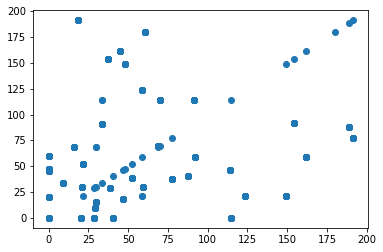

t+1 vs t-31


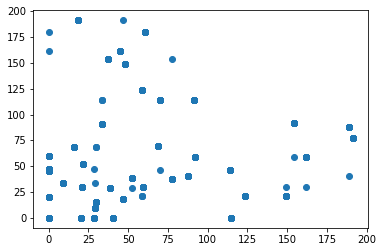

t+1 vs t-32


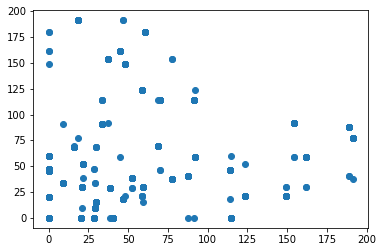

t+1 vs t-33


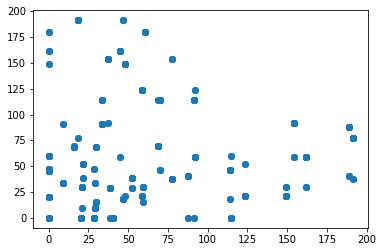

t+1 vs t-34


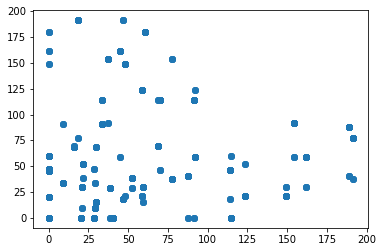

t+1 vs t-35


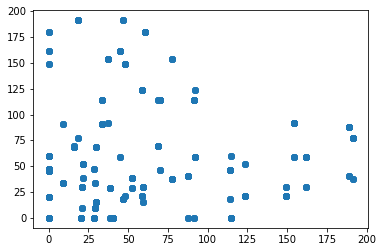

t+1 vs t-36


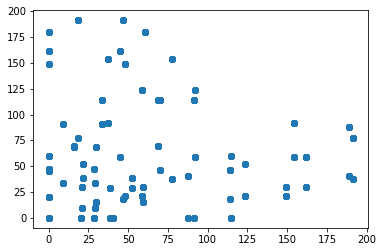

t+1 vs t-37


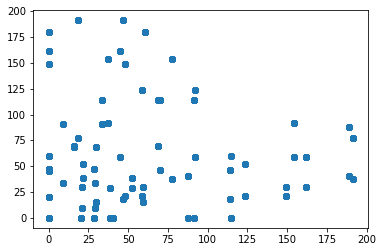

t+1 vs t-38


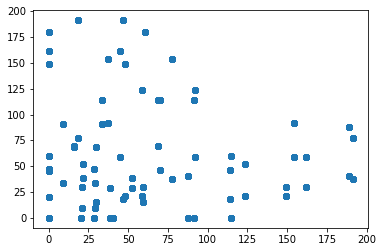

t+1 vs t-39


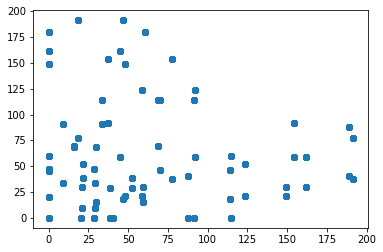

t+1 vs t-40


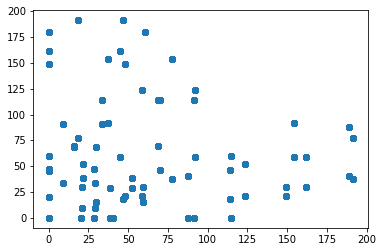

t+1 vs t-41


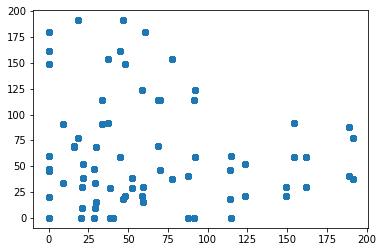

t+1 vs t-42


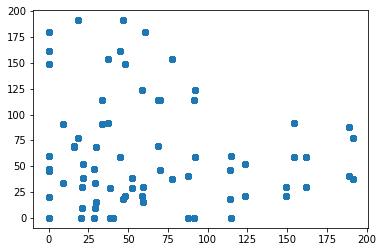

t+1 vs t-43


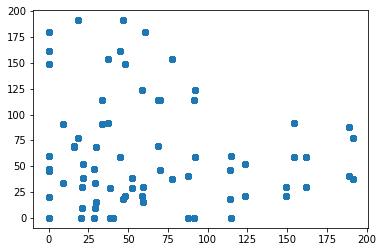

t+1 vs t-44


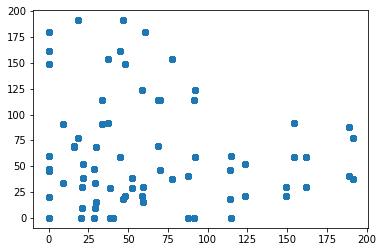

t+1 vs t-45


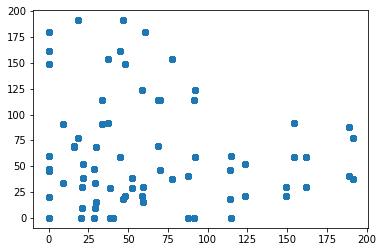

t+1 vs t-46


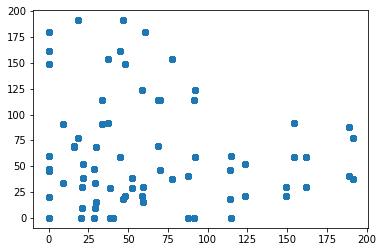

t+1 vs t-47


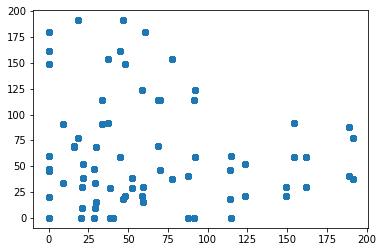

t+1 vs t-48


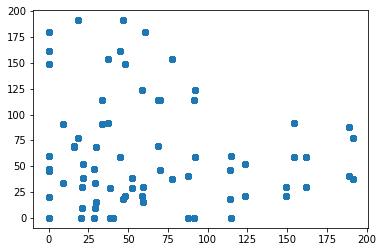

t+1 vs t-49


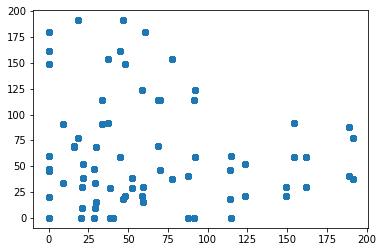

t+1 vs t-50


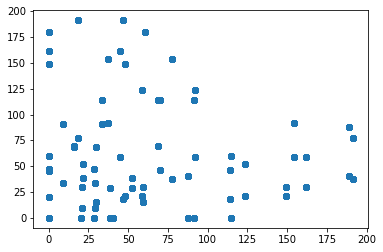

t+1 vs t-51


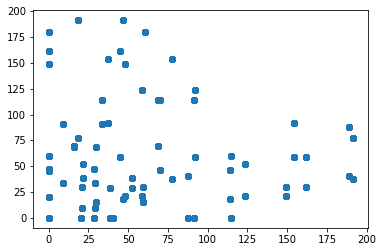

t+1 vs t-52


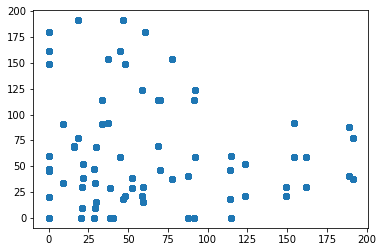

t+1 vs t-53


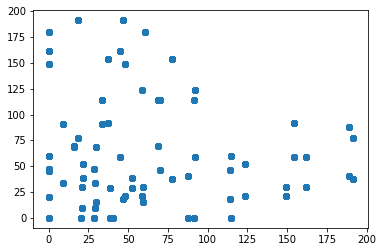

t+1 vs t-54


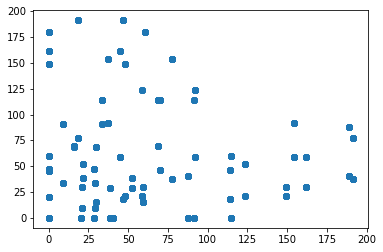

t+1 vs t-55


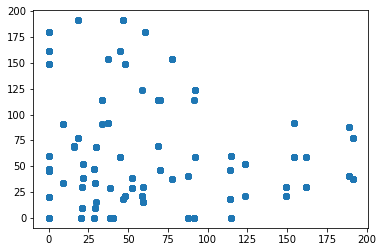

t+1 vs t-56


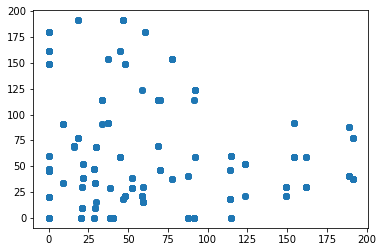

t+1 vs t-57


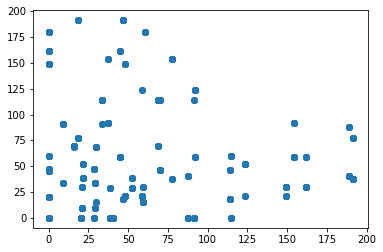

t+1 vs t-58


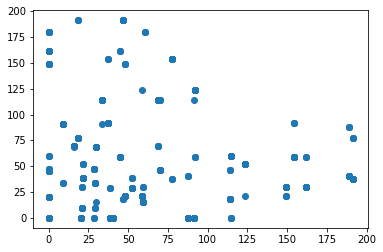

t+1 vs t-59


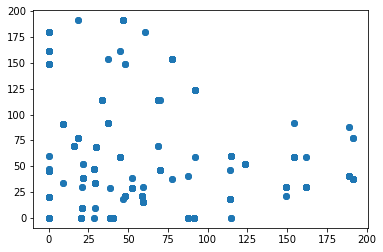

t+1 vs t-60


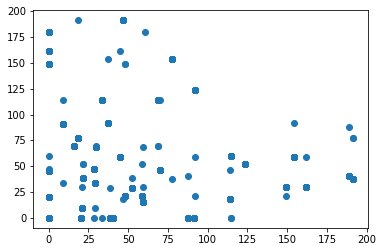

t+1 vs t-61


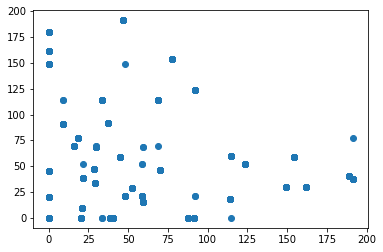

t+1 vs t-62


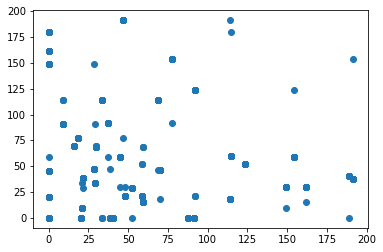

t+1 vs t-63


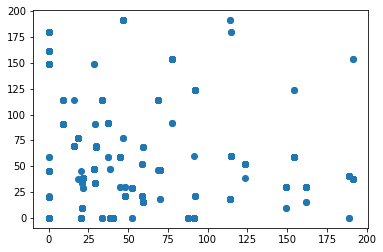

t+1 vs t-64


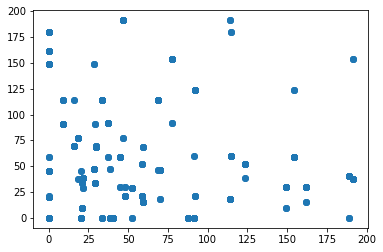

t+1 vs t-65


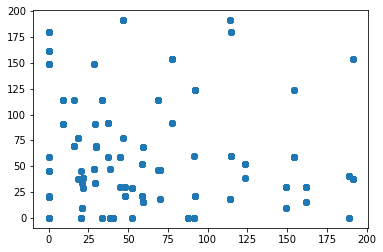

t+1 vs t-66


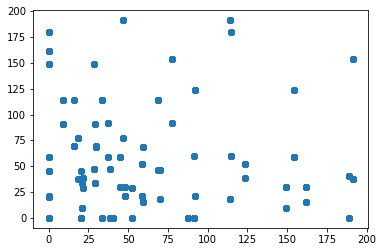

t+1 vs t-67


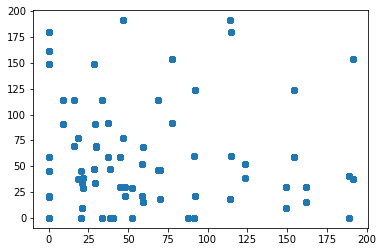

t+1 vs t-68


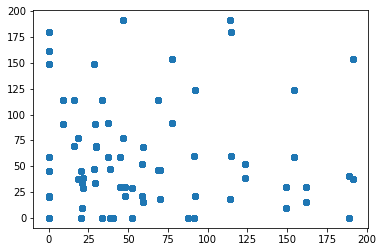

t+1 vs t-69


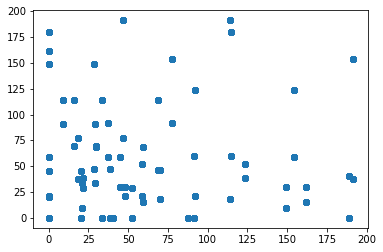

t+1 vs t-70


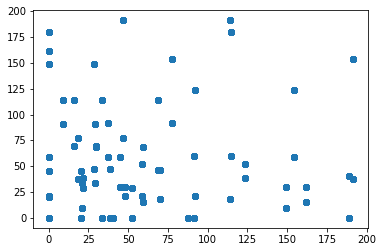

t+1 vs t-71


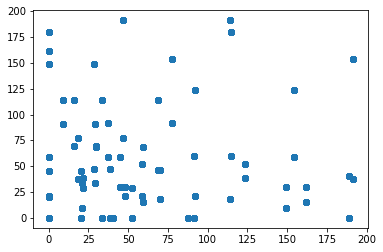

t+1 vs t-72


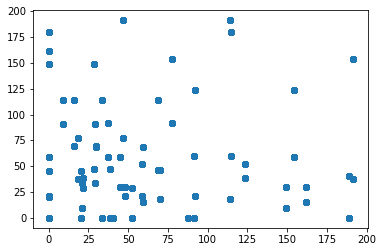

t+1 vs t-73


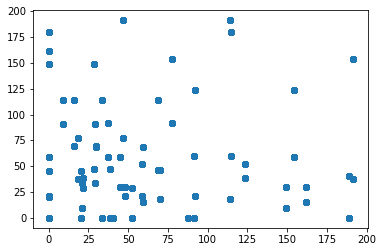

t+1 vs t-74


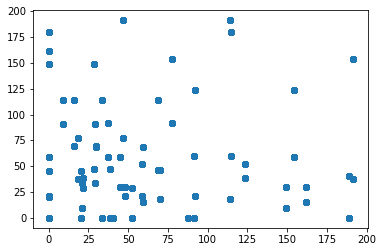

t+1 vs t-75


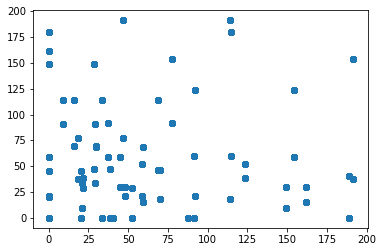

t+1 vs t-76


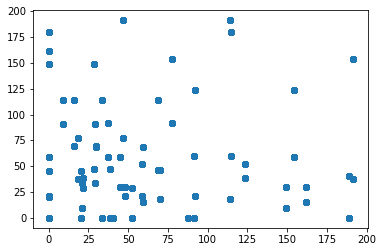

t+1 vs t-77


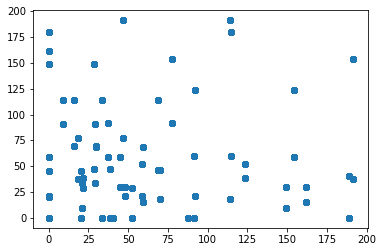

t+1 vs t-78


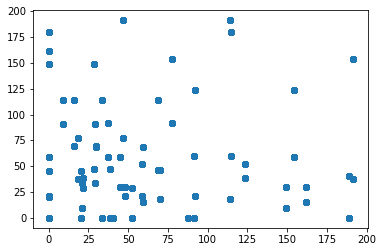

t+1 vs t-79


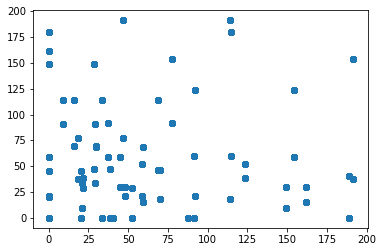

t+1 vs t-80


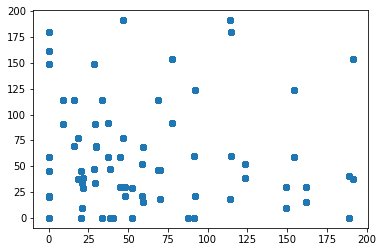

t+1 vs t-81


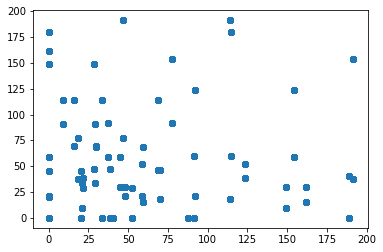

t+1 vs t-82


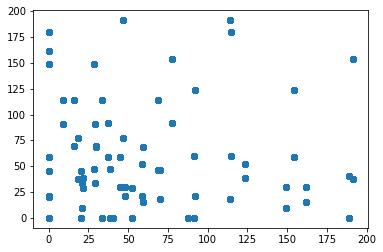

t+1 vs t-83


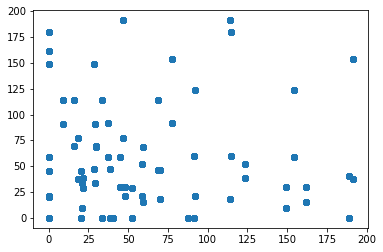

t+1 vs t-84


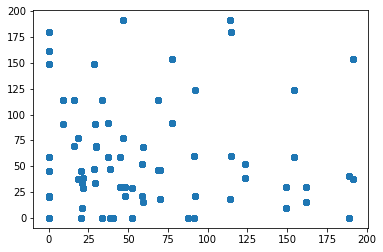

t+1 vs t-85


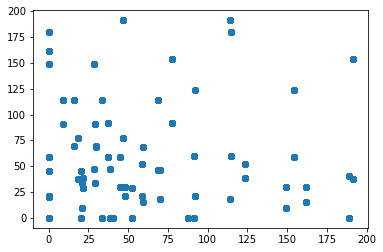

t+1 vs t-86


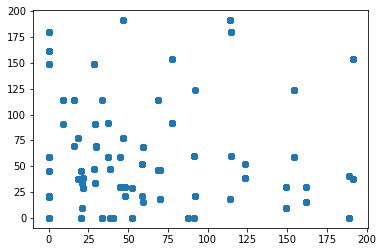

t+1 vs t-87


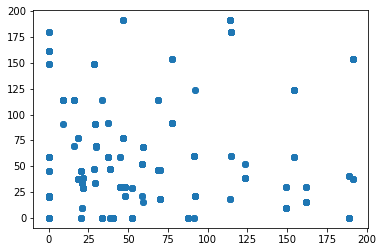

t+1 vs t-88


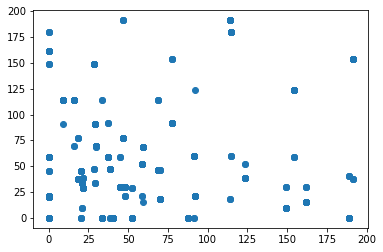

t+1 vs t-89


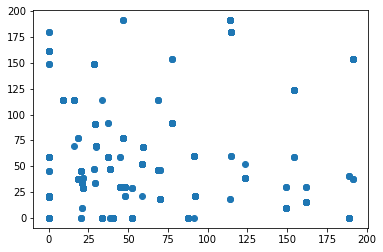

t+1 vs t-90


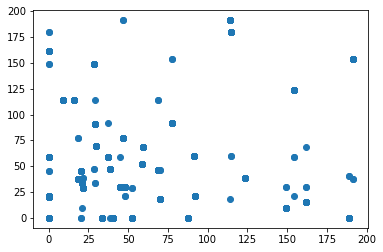

t+1 vs t-91


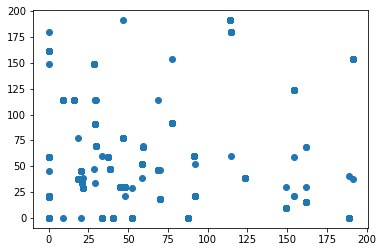

t+1 vs t-92


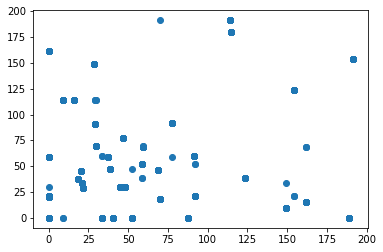

t+1 vs t-93


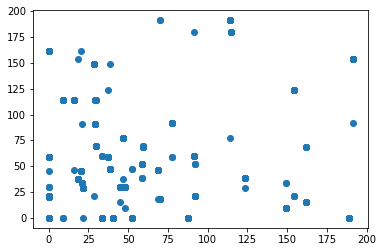

t+1 vs t-94


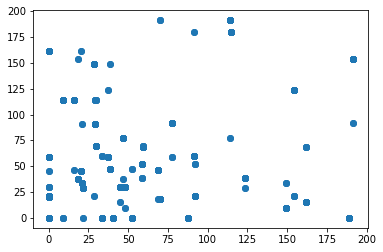

t+1 vs t-95


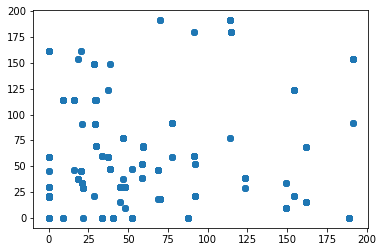

t+1 vs t-96


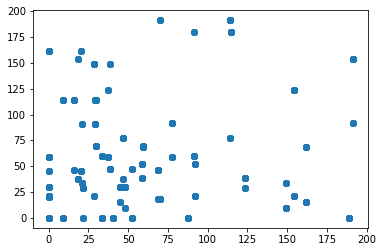

t+1 vs t-97


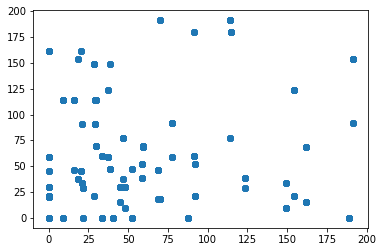

t+1 vs t-98


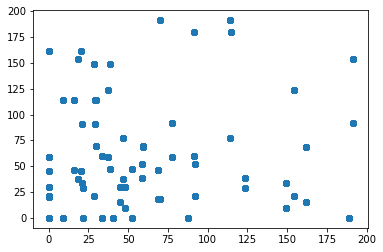

t+1 vs t-99


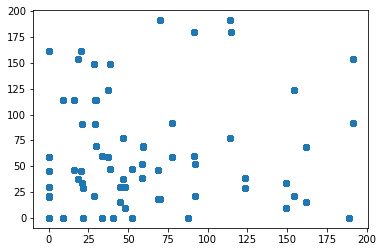

t+1 vs t-100


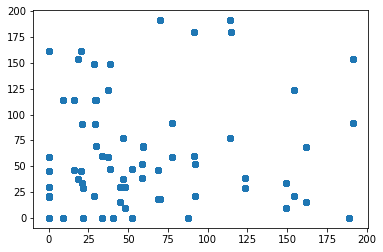

In [63]:
values = DataFrame(transacciones_mfilled_df.values)
# lags = transacciones_mfilled_df.size
lags = 100
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
for i in range(1,(lags + 1)):
	print('t+1 vs t-' + str(i))
	pyplot.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
	pyplot.show()

In [64]:
"""
Vemos que hay buena correlacion desde y(t+1) hasta y(t-30).
Pasaba justo lo mismo con la serie de supermercados.
"""

'\nVemos que hay buena correlacion desde y(t+1) hasta y(t-30).\nPasaba justo lo mismo con la serie de supermercados.\n'

In [65]:
# 6. Time Series Autocorrelation Plots

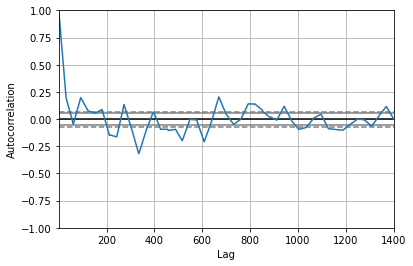

In [66]:
autocorrelation_plot(transacciones_mfilled_df)
pyplot.show()

In [67]:
"""
Vemos que hay una fuerte correlacion (corr > 0.5) entre y(t+1) hasta aproximadamente el lag 30; y correlacion estadisticamente
significativa hasta el lag 50.

Además a partir del lag 200 hay otros grupos de lags con correlación estadisticamente significativa (como en 'supermercados').
Por tanto vamos a intentar modelar la serie temporal y ver cuanto error estamos cometiendo.
"""

"\nVemos que hay una fuerte correlacion (corr > 0.5) entre y(t+1) hasta aproximadamente el lag 30; y correlacion estadisticamente\nsignificativa hasta el lag 50.\n\nAdemás a partir del lag 200 hay otros grupos de lags con correlación estadisticamente significativa (como en 'supermercados').\nPor tanto vamos a intentar modelar la serie temporal y ver cuanto error estamos cometiendo.\n"

In [70]:
# a continuación vamos a estimar con prophet la serie temporal del importe con los datos del dataframe
# 'transacciones_mfilled_df'
# vamos a entrenar la serie desde el segundo mes de transacciones_mfilled_df hasta el penúltimo mes de
# transacciones_mfilled_df porque para el primer y ultimo mes de datos en ocasiones no se dispondrá del mes completo
# con lo que tenemos valores inferiores de IMPORTE para esos meses que distorsionan el calculo de la serie temporal

In [71]:
prophet_train_df = transacciones_mfilled_df.copy()
prophet_train_df

,IMPORTE
2016-10-01,180.1
2016-10-02,180.1
2016-10-03,180.1
2016-10-04,180.1
2016-10-05,180.1
...,...
2020-07-27,188.8
2020-07-28,188.8
2020-07-29,188.8
2020-07-30,188.8


In [72]:
# Time Series Forecasting With Prophet in Python
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [73]:
# Fit Prophet Model

In [74]:
# para los datos de training tenemos que quitar los datos del mes en el que pedimos la estimación.
# ya que si hacemos la estimación al principio del mes el gasto en supermercados sera mucho menor respecto al gasto
# en supermercados de un mes completo similar

In [75]:
# hacemos una columna con el indice que se llame fecha
prophet_train_df['FECHA'] = prophet_train_df.index
prophet_train_df

,IMPORTE,FECHA
2016-10-01,180.1,2016-10-01
2016-10-02,180.1,2016-10-02
2016-10-03,180.1,2016-10-03
2016-10-04,180.1,2016-10-04
2016-10-05,180.1,2016-10-05
...,...,...
2020-07-27,188.8,2020-07-27
2020-07-28,188.8,2020-07-28
2020-07-29,188.8,2020-07-29
2020-07-30,188.8,2020-07-30


In [76]:
# calculamos el ultimo año
last_year = prophet_train_df['FECHA'].dt.year.max()
last_year

2020

In [77]:
# calculamos el ultimo mes del ultimo año
last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()
last_month

<ipython-input-77-27e5322a8c95>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prophet_train_df[str(last_year)]['FECHA'].dt.month.max()


7

In [78]:
# hacemos un string con el ultimo año y mes para hacer una mascara
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-7'

In [79]:
# calculamos la fecha maxima para quitarnos las transacciones en fecha iguales o posterior a esta
maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()
maximum_date_obj

<ipython-input-79-f05c0beb5200>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  maximum_date_obj = prophet_train_df[last_year_month]['FECHA'].min()


Timestamp('2020-07-01 00:00:00')

In [80]:
# hacemos una mascara para quitar las filas del ultimo mes
before_maximum_date_ser = prophet_train_df['FECHA'] < maximum_date_obj
before_maximum_date_ser

2016-10-01     True
2016-10-02     True
2016-10-03     True
2016-10-04     True
2016-10-05     True
              ...  
2020-07-27    False
2020-07-28    False
2020-07-29    False
2020-07-30    False
2020-07-31    False
Freq: D, Name: FECHA, Length: 1400, dtype: bool

In [81]:
# aplicamos la mascara
prophet_train_df = prophet_train_df.loc[before_maximum_date_ser]
prophet_train_df

,IMPORTE,FECHA
2016-10-01,180.1,2016-10-01
2016-10-02,180.1,2016-10-02
2016-10-03,180.1,2016-10-03
2016-10-04,180.1,2016-10-04
2016-10-05,180.1,2016-10-05
...,...,...
2020-06-26,87.6,2020-06-26
2020-06-27,87.6,2020-06-27
2020-06-28,87.6,2020-06-28
2020-06-29,87.6,2020-06-29


In [82]:
# también tenemos que quitar del dataframe los datos del primer mes porque también puede estar no completo y nos
# desvirtúa también la serie temporal del entrenamiento

In [83]:
# calculamos el primer año del dataframe
first_year = prophet_train_df['FECHA'].dt.year.min()
first_year

2016

In [84]:
# calculamos el primer mes del primer año
first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()
first_month

<ipython-input-84-80bd3efc9827>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_month = prophet_train_df[str(first_year)]['FECHA'].dt.month.min()


10

In [85]:
# hacemos un string con el primer mes del primer año para hacer una mascara
first_year_month = str(first_year) + '-' + str(first_month)
first_year_month

'2016-10'

In [86]:
# calculamos la fecha minima para quedarnos con todas las transacciones del dataframe posteriores a esa fecha
minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()
minimum_date_obj

<ipython-input-86-51c03972f9c0>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prophet_train_df[first_year_month]['FECHA'].max()


Timestamp('2016-10-31 00:00:00')

In [87]:
# hago una mascara para quitar las filas del primer mes
after_minimum_date_ser = prophet_train_df['FECHA'] > minimum_date_obj
after_minimum_date_ser

2016-10-01    False
2016-10-02    False
2016-10-03    False
2016-10-04    False
2016-10-05    False
              ...  
2020-06-26     True
2020-06-27     True
2020-06-28     True
2020-06-29     True
2020-06-30     True
Freq: D, Name: FECHA, Length: 1369, dtype: bool

In [88]:
# aplicamos la mascara anterior
prophet_train_df = prophet_train_df.loc[after_minimum_date_ser]
prophet_train_df

,IMPORTE,FECHA
2016-11-01,60.3,2016-11-01
2016-11-02,60.3,2016-11-02
2016-11-03,60.3,2016-11-03
2016-11-04,60.3,2016-11-04
2016-11-05,60.3,2016-11-05
...,...,...
2020-06-26,87.6,2020-06-26
2020-06-27,87.6,2020-06-27
2020-06-28,87.6,2020-06-28
2020-06-29,87.6,2020-06-29


In [89]:
# reordenamos las columnas de prophet_train_df
prophet_train_df = prophet_train_df[['FECHA', 'IMPORTE']]
prophet_train_df

,FECHA,IMPORTE
2016-11-01,2016-11-01,60.3
2016-11-02,2016-11-02,60.3
2016-11-03,2016-11-03,60.3
2016-11-04,2016-11-04,60.3
2016-11-05,2016-11-05,60.3
...,...,...
2020-06-26,2020-06-26,87.6
2020-06-27,2020-06-27,87.6
2020-06-28,2020-06-28,87.6
2020-06-29,2020-06-29,87.6


In [90]:
# prepare expected column names
prophet_train_df.columns = ['ds', 'y']
prophet_train_df

,ds,y
2016-11-01,2016-11-01,60.3
2016-11-02,2016-11-02,60.3
2016-11-03,2016-11-03,60.3
2016-11-04,2016-11-04,60.3
2016-11-05,2016-11-05,60.3
...,...,...
2020-06-26,2020-06-26,87.6
2020-06-27,2020-06-27,87.6
2020-06-28,2020-06-28,87.6
2020-06-29,2020-06-29,87.6


In [91]:
# reseteamos el indice del dataframe
prophet_train_df.reset_index(drop=True, inplace=True)
prophet_train_df

,ds,y
0,2016-11-01,60.3
1,2016-11-02,60.3
2,2016-11-03,60.3
3,2016-11-04,60.3
4,2016-11-05,60.3
...,...,...
1333,2020-06-26,87.6
1334,2020-06-27,87.6
1335,2020-06-28,87.6
1336,2020-06-29,87.6


In [92]:
# esto no va en produccion

# comprobamos q 'ds' es 'datetime'
prophet_train_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [93]:
# define the model
model = Prophet()

In [94]:
# fit the model
model.fit(prophet_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
# esto no va en produccion

# vamos a pedirle a prophet que haga la prediccion hasta el ultimo dia del mes siguiente al de 'last_date_obj'
last_date_obj

Timestamp('2020-07-26 00:00:00')

In [96]:
# vamos a pedirle a prophet que haga la predicción hasta el ultimo dia del mes siguiente al de 'last_date_obj'
future_out_sample = transacciones_mfilled_df.copy()
future_out_sample

,IMPORTE
2016-10-01,180.1
2016-10-02,180.1
2016-10-03,180.1
2016-10-04,180.1
2016-10-05,180.1
...,...
2020-07-27,188.8
2020-07-28,188.8
2020-07-29,188.8
2020-07-30,188.8


In [97]:
# hacemos una columna 'FECHA' con el indice
future_out_sample['FECHA'] = future_out_sample.index
future_out_sample

,IMPORTE,FECHA
2016-10-01,180.1,2016-10-01
2016-10-02,180.1,2016-10-02
2016-10-03,180.1,2016-10-03
2016-10-04,180.1,2016-10-04
2016-10-05,180.1,2016-10-05
...,...,...
2020-07-27,188.8,2020-07-27
2020-07-28,188.8,2020-07-28
2020-07-29,188.8,2020-07-29
2020-07-30,188.8,2020-07-30


In [98]:
# hacemos un drop de la columna 'IMPORTE'
future_out_sample.drop(columns='IMPORTE', inplace=True)
future_out_sample

,FECHA
2016-10-01,2016-10-01
2016-10-02,2016-10-02
2016-10-03,2016-10-03
2016-10-04,2016-10-04
2016-10-05,2016-10-05
...,...
2020-07-27,2020-07-27
2020-07-28,2020-07-28
2020-07-29,2020-07-29
2020-07-30,2020-07-30


In [99]:
# calculamos la fecha del ultimo dia 
target_date_obj = last_date_obj + DateOffset(months=1) + MonthEnd(1)
target_date_obj

Timestamp('2020-08-31 00:00:00')

In [100]:
# calculamos el rango de fechas de la estimación
idx = date_range(start=prophet_train_df.ds.min(), end=target_date_obj)
idx

DatetimeIndex(['2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06', '2016-11-07', '2016-11-08',
               '2016-11-09', '2016-11-10',
               ...
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31'],
              dtype='datetime64[ns]', length=1400, freq='D')

In [101]:
# esto no va en produccion

# comprobamos q el indice del dataframe es del formato 'DatetimeIndex'
type(future_out_sample.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [102]:
# rehacemos el indice de future_out_sample de acuerdo a las fechas de idx
future_out_sample = future_out_sample.reindex(idx)
future_out_sample

,FECHA
2016-11-01,2016-11-01
2016-11-02,2016-11-02
2016-11-03,2016-11-03
2016-11-04,2016-11-04
2016-11-05,2016-11-05
...,...
2020-08-27,NaT
2020-08-28,NaT
2020-08-29,NaT
2020-08-30,NaT


In [103]:
# hacemos una columna con el nuevo indice
future_out_sample.reset_index(drop=False, inplace=True)
future_out_sample

,index,FECHA
0,2016-11-01,2016-11-01
1,2016-11-02,2016-11-02
2,2016-11-03,2016-11-03
3,2016-11-04,2016-11-04
4,2016-11-05,2016-11-05
...,...,...
1395,2020-08-27,NaT
1396,2020-08-28,NaT
1397,2020-08-29,NaT
1398,2020-08-30,NaT


In [104]:
# hacemos un drop de la columna 'FECHA'
future_out_sample.drop(columns='FECHA', inplace=True)
future_out_sample

,index
0,2016-11-01
1,2016-11-02
2,2016-11-03
3,2016-11-04
4,2016-11-05
...,...
1395,2020-08-27
1396,2020-08-28
1397,2020-08-29
1398,2020-08-30


In [105]:
# renombramos la columna del dataframe a 'ds'
future_out_sample.columns = ['ds']
future_out_sample

,ds
0,2016-11-01
1,2016-11-02
2,2016-11-03
3,2016-11-04
4,2016-11-05
...,...
1395,2020-08-27
1396,2020-08-28
1397,2020-08-29
1398,2020-08-30


In [106]:
# esto no va en produccion

# comprobamos que ds es del tipo datetime64
future_out_sample.dtypes

ds    datetime64[ns]
dtype: object

In [107]:
# use the model to make a forecast
forecast_df = model.predict(future_out_sample)

In [108]:
# esto no va en produccion

# summarize the forecast
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2016-11-01,33.369814,-18.079212,85.766129
1,2016-11-02,35.950260,-11.584966,88.991642
2,2016-11-03,38.293032,-11.430714,85.269590
3,2016-11-04,39.612860,-8.523307,86.482876
4,2016-11-05,40.427112,-9.545238,87.786217
...,...,...,...,...
1395,2020-08-27,11.153153,-38.705326,60.338413
1396,2020-08-28,6.637619,-43.650538,54.721338
1397,2020-08-29,1.544355,-45.719903,50.276292
1398,2020-08-30,-1.215892,-52.806909,48.113392


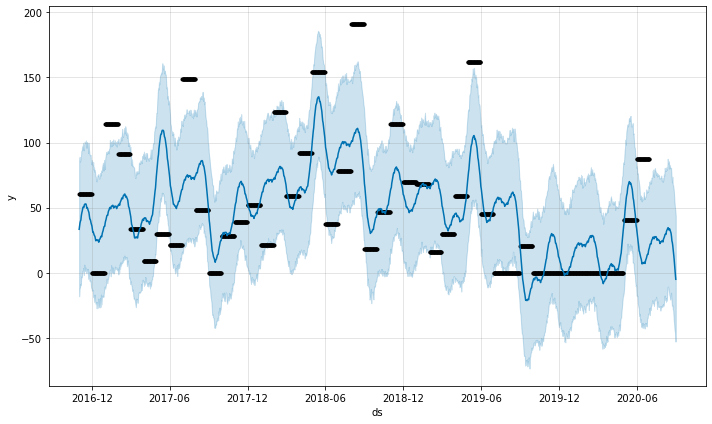

In [109]:
# esto no va en produccion

# plot forecast
model.plot(forecast_df)
pyplot.show()

In [110]:
# nos quedamos con las columnas 'ds' y 'yhat'
forecast_df = forecast_df[['ds', 'yhat']]
forecast_df

,ds,yhat
0,2016-11-01,33.369814
1,2016-11-02,35.950260
2,2016-11-03,38.293032
3,2016-11-04,39.612860
4,2016-11-05,40.427112
...,...,...
1395,2020-08-27,11.153153
1396,2020-08-28,6.637619
1397,2020-08-29,1.544355
1398,2020-08-30,-1.215892


In [111]:
# nos quedamos con las filas del ultimo mes que es para el que hemos hecho la predicción
# calculamos el ultimo año
last_year = forecast_df['ds'].dt.year.max()
last_year

2020

In [112]:
# calculamos el ultimo mes del ultimo año creándonos un dataframe donde al final tendremos la estimación del ultimo mes
prediction_df = forecast_df.copy()
prediction_df

,ds,yhat
0,2016-11-01,33.369814
1,2016-11-02,35.950260
2,2016-11-03,38.293032
3,2016-11-04,39.612860
4,2016-11-05,40.427112
...,...,...
1395,2020-08-27,11.153153
1396,2020-08-28,6.637619
1397,2020-08-29,1.544355
1398,2020-08-30,-1.215892


In [113]:
# rehacemos el indice con la FECHA columna 'ds'
prediction_df.set_index('ds', drop=False, inplace=True)
prediction_df

,ds,yhat
ds,,
2016-11-01,2016-11-01,33.369814
2016-11-02,2016-11-02,35.950260
2016-11-03,2016-11-03,38.293032
2016-11-04,2016-11-04,39.612860
2016-11-05,2016-11-05,40.427112
...,...,...
2020-08-27,2020-08-27,11.153153
2020-08-28,2020-08-28,6.637619
2020-08-29,2020-08-29,1.544355


In [114]:
# calculamos el ultimo mes del ultimo año
last_month = prediction_df[str(last_year)]['ds'].dt.month.max()
last_month

<ipython-input-114-a34f31bb08de>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  last_month = prediction_df[str(last_year)]['ds'].dt.month.max()


8

In [115]:
# hago una variable str con el ultimo año y el ultimo mes
last_year_month = str(last_year) + '-' + str(last_month)
last_year_month

'2020-8'

In [118]:
# calculo la fecha minima a partir de la cual me quedo con los datos
minimum_date_obj = prediction_df[last_year_month]['ds'].min()
minimum_date_obj

<ipython-input-118-63931a1604df>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  minimum_date_obj = prediction_df[last_year_month]['ds'].min()


Timestamp('2020-08-01 00:00:00')

In [119]:
# hago una mascara para quedarme con las filas del ultimo año y del ultimo mes
after_minimum_date_ser = prediction_df['ds'] >= minimum_date_obj
after_minimum_date_ser

ds
2016-11-01    False
2016-11-02    False
2016-11-03    False
2016-11-04    False
2016-11-05    False
              ...  
2020-08-27     True
2020-08-28     True
2020-08-29     True
2020-08-30     True
2020-08-31     True
Name: ds, Length: 1400, dtype: bool

In [120]:
# hago una mascara para quedarme con las filas del ultimo año y del ultimo mes
after_minimum_date_ser = prediction_df['ds'] >= minimum_date_obj
after_minimum_date_ser

ds
2016-11-01    False
2016-11-02    False
2016-11-03    False
2016-11-04    False
2016-11-05    False
              ...  
2020-08-27     True
2020-08-28     True
2020-08-29     True
2020-08-30     True
2020-08-31     True
Name: ds, Length: 1400, dtype: bool

In [121]:
# aplico la mascara para quedarme finalmente con las filas de las transacciones del ultimo mes y del ultimo año
prediction_df = prediction_df.loc[after_minimum_date_ser]
prediction_df

,ds,yhat
ds,,
2020-08-01,2020-08-01,23.634411
2020-08-02,2020-08-02,25.511862
2020-08-03,2020-08-03,26.503372
2020-08-04,2020-08-04,27.138966
2020-08-05,2020-08-05,28.414623
...,...,...
2020-08-27,2020-08-27,11.153153
2020-08-28,2020-08-28,6.637619
2020-08-29,2020-08-29,1.544355


In [122]:
# hacemos un drop de la columna con las fechas
prediction_df.drop(columns='ds', inplace=True)
prediction_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,yhat
ds,
2020-08-01,23.634411
2020-08-02,25.511862
2020-08-03,26.503372
2020-08-04,27.138966
2020-08-05,28.414623
...,...
2020-08-27,11.153153
2020-08-28,6.637619
2020-08-29,1.544355


In [123]:
# damos la predicción final como la media de valores predichos para el mes
final_prediction = float(prediction_df.mean())
final_prediction

24.361751740795658

In [124]:
# a continuación comprobamos que la media de transacciones en restaurantes desde el dia 1 del mes anterior es mayor 
# que 0 para poder dar la predicción como valida 

In [125]:
# esto no va en produccion

transacciones_mfilled_df

,IMPORTE
2016-10-01,180.1
2016-10-02,180.1
2016-10-03,180.1
2016-10-04,180.1
2016-10-05,180.1
...,...
2020-07-27,188.8
2020-07-28,188.8
2020-07-29,188.8
2020-07-30,188.8


In [126]:
# esto no va en produccion

last_date_obj

Timestamp('2020-07-26 00:00:00')

In [127]:
# calculamos la fecha del primer dia del mes anterior a la petición
target_date_obj = last_date_obj - DateOffset(months=1) - MonthBegin(1)
target_date_obj

Timestamp('2020-06-01 00:00:00')

In [128]:
# hago una mascara para solo quedarme con las filas del dataframe a partir de target_date_obj
after_target_date_ser = transacciones_mfilled_df.index >= target_date_obj
after_target_date_ser

array([False, False, False, ...,  True,  True,  True])

In [129]:
# aplico la mascara
final_mean_df = transacciones_mfilled_df.loc[after_target_date_ser]
final_mean_df

,IMPORTE
2020-06-01,87.6
2020-06-02,87.6
2020-06-03,87.6
2020-06-04,87.6
2020-06-05,87.6
...,...
2020-07-27,188.8
2020-07-28,188.8
2020-07-29,188.8
2020-07-30,188.8


In [130]:
# calculo la media final desde el dia 1 del mes anterior a la petición
final_mean = float(final_mean_df.mean())
final_mean

139.02950819672137

In [131]:
# hago el chequeo final de que la predicción sea valida
valid_prediction = False

if final_mean != 0:
    valid_prediction = True
elif float(final_prediction) == 0:
    valid_prediction = True

valid_prediction

True

In [132]:
# hago un dataframe para calcular el año y mes de la predicción
final_date_month_df = prediction_df.copy()
final_date_month_df

,yhat
ds,
2020-08-01,23.634411
2020-08-02,25.511862
2020-08-03,26.503372
2020-08-04,27.138966
2020-08-05,28.414623
...,...
2020-08-27,11.153153
2020-08-28,6.637619
2020-08-29,1.544355


In [133]:
# hacemos una columna con el indice
final_date_month_df.reset_index(inplace=True)
final_date_month_df

,ds,yhat
0,2020-08-01,23.634411
1,2020-08-02,25.511862
2,2020-08-03,26.503372
3,2020-08-04,27.138966
4,2020-08-05,28.414623
...,...,...
26,2020-08-27,11.153153
27,2020-08-28,6.637619
28,2020-08-29,1.544355
29,2020-08-30,-1.215892


In [134]:
# calculo el año de la predicción
final_year = final_date_month_df['ds'].dt.year.max()
final_year

2020

In [135]:
# calculo el mes de la predicción
final_month = final_date_month_df['ds'].dt.month.max()
final_month

8

In [136]:
# paso de numero a nombre el mes de la predicción
datetime_object = datetime.strptime(str(final_month), "%m")
final_month_str = datetime_object.strftime("%B")
final_month_str

'August'

In [138]:
# damos resultados finales
print('Tus gasto aproximado en restaurantes/salidas en ' + final_month_str + '-' + str(final_year) +
      ' sera: ' + str(5 * round(final_prediction / 5)) + ' eur')
print('Predicción válida: ' + str(valid_prediction))

Tus gasto aproximado en restaurantes/salidas en August-2020 sera: 25 eur
Predicción válida: True


In [139]:
!python -V

Python 3.8.10


In [140]:
!pip3 list

Package                            Version


---------------------------------- -------------------
absl-py                            0.12.0
aiohttp                            3.7.4
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.10.0
anyio                              2.2.0
AnyQt                              0.0.13
argh                               0.26.2
argon2-cffi                        20.1.0
arviz                              0.11.2
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      3.0.1
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.6
Babel                              2.9.1
backcall                           0.

pywinpty                           0.5.7
PyYAML                             5.4.1
pyzmq                              20.0.0
qasync                             0.16.0
QDarkStyle                         3.0.2
QtAwesome                          1.0.2
qtconsole                          5.0.3
QtPy                               1.9.0
regex                              2021.4.4
requests                           2.25.1
requests-oauthlib                  1.3.0
rfc3986                            1.5.0
rope                               0.18.0
rsa                                4.7.2
Rtree                              0.9.7
ruamel-yaml-conda                  0.15.100
scikit-image                       0.18.1
scikit-learn                       0.24.2
scipy                              1.4.1
seaborn                            0.11.1
Send2Trash                         1.5.0
serverfiles                        0.3.0
setuptools                         52.0.0.post20210125
setuptools-git                

In [141]:
!pip3 freeze

absl-py @ file:///C:/ci/absl-py_1615411229697/work


aiohttp @ file:///C:/ci/aiohttp_1614361024229/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.0.3
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1621348054992/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
AnyQt @ file:///home/conda/feedstock_root/build_artifacts/anyqt_1620306236038/work
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
arviz @ file:///tmp/build/80754af9/arviz_1614019183254/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
async-timeout==3.0.1
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754a

QDarkStyle @ file:///tmp/build/80754af9/qdarkstyle_1617386714626/work
QtAwesome @ file:///tmp/build/80754af9/qtawesome_1615991616277/work
qtconsole @ file:///tmp/build/80754af9/qtconsole_1616775094278/work
QtPy==1.9.0
regex @ file:///C:/ci/regex_1617569893741/work
requests @ file:///tmp/build/80754af9/requests_1608241421344/work
requests-oauthlib==1.3.0
rfc3986 @ file:///home/conda/feedstock_root/build_artifacts/rfc3986_1620442452971/work
rope @ file:///tmp/build/80754af9/rope_1602264064449/work
rsa @ file:///tmp/build/80754af9/rsa_1614366226499/work
Rtree @ file:///C:/ci/rtree_1618421009405/work
ruamel-yaml-conda @ file:///C:/ci/ruamel_yaml_1616016967756/work
scikit-image==0.18.1
scikit-learn @ file:///C:/ci/scikit-learn_1621370563523/work
scipy==1.4.1
seaborn @ file:///tmp/build/80754af9/seaborn_1608578541026/work
Send2Trash @ file:///tmp/build/80754af9/send2trash_1607525499227/work
serverfiles==0.3.0
setuptools-git==1.2
simplegeneric==0.8.1
singledispatch @ file:///tmp/build/80754af

In [144]:
!pip3 freeze > requirements.txt